Raw data loaded successfully.
(41457, 22)
Null value counts:
 time                   0
latitude               0
longitude              0
depth                  0
mag                    0
magType                0
nst                19115
gap                12232
dmin               29334
rms                  881
net                    0
id                     0
updated                0
place                  0
type                   0
horizontalError    30649
depthError         16182
magError           29509
magNst              5916
status                 0
locationSource         0
magSource              0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41457 entries, 0 to 41456
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time             41457 non-null  object 
 1   latitude         41457 non-null  float64
 2   longitude        41457 non-null  float64
 3   depth            41457 non-null

<Figure size 1000x600 with 0 Axes>

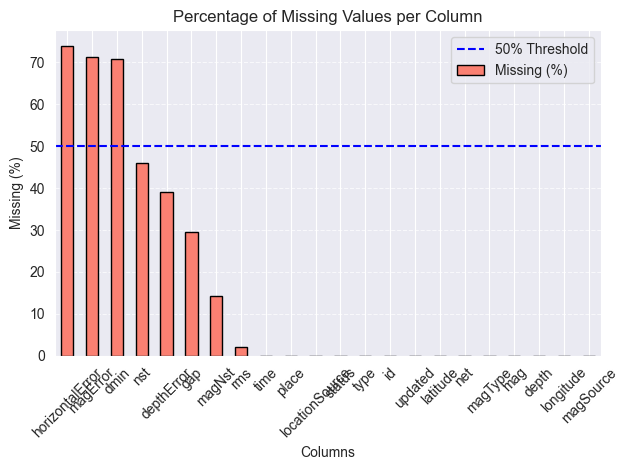

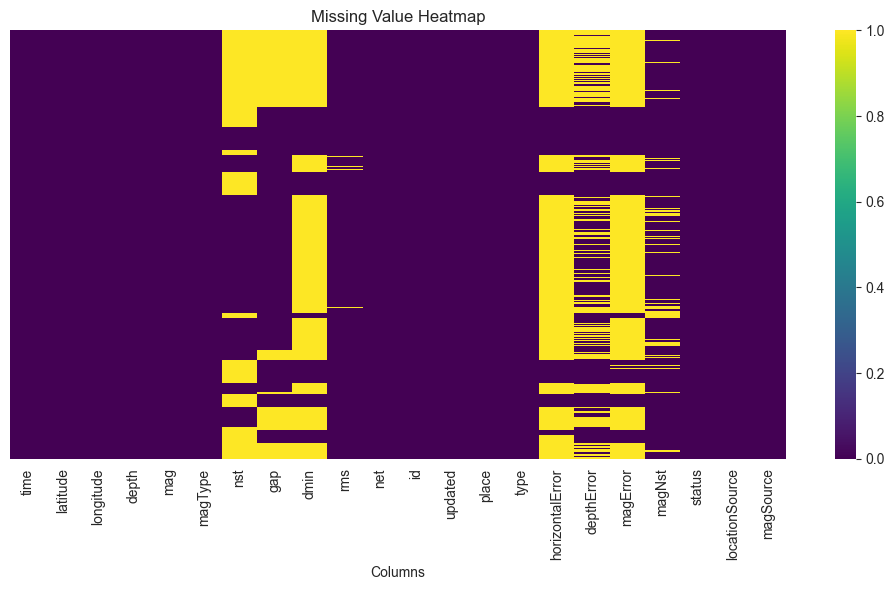

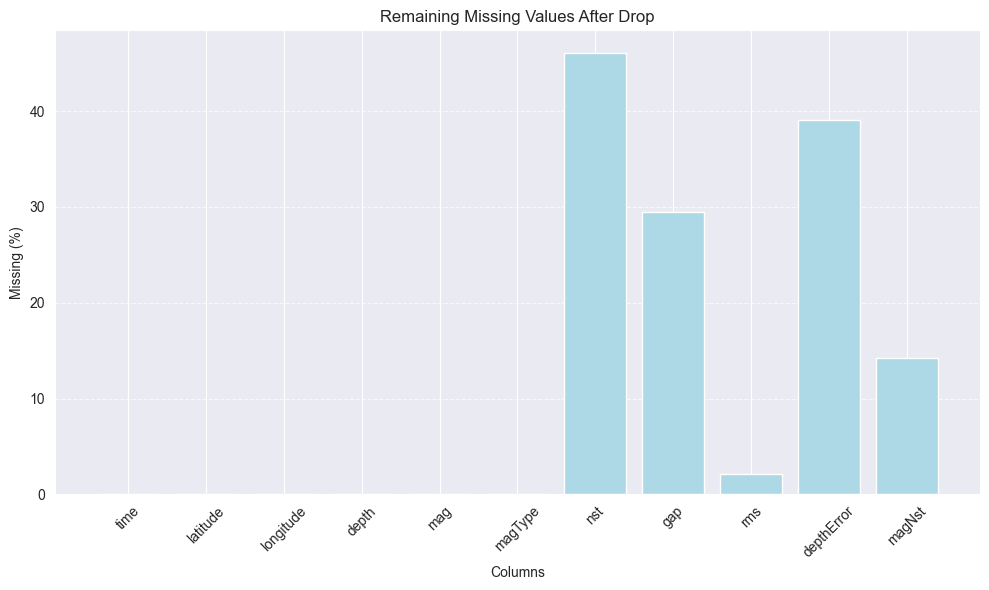

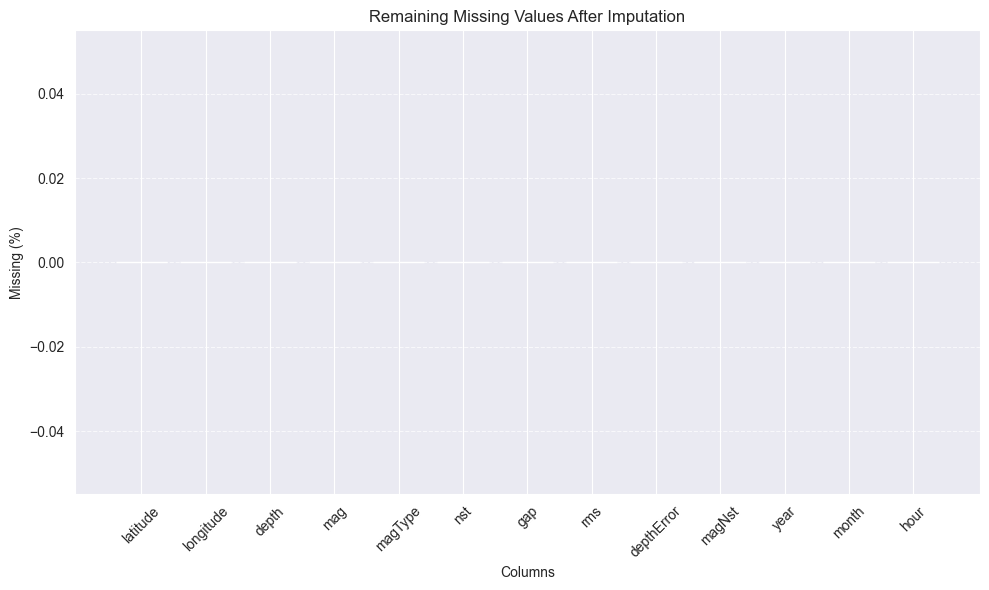

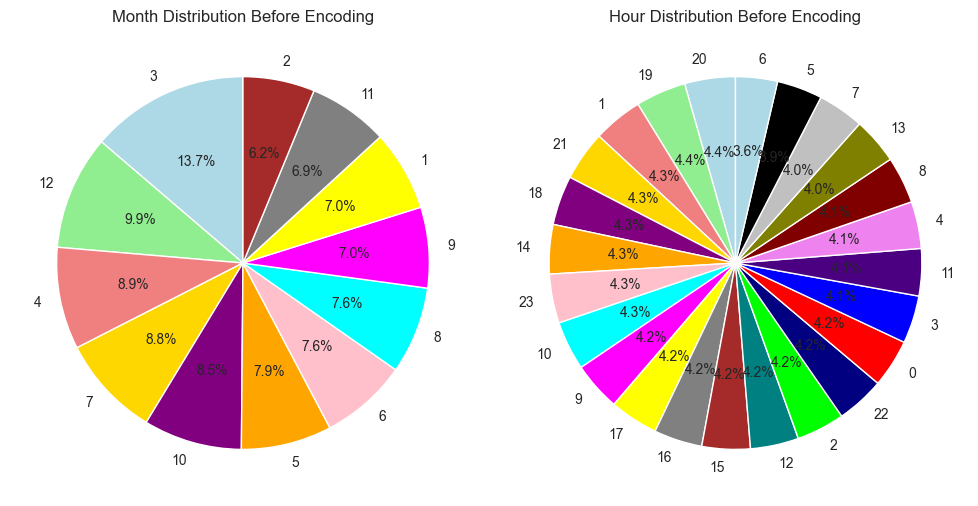

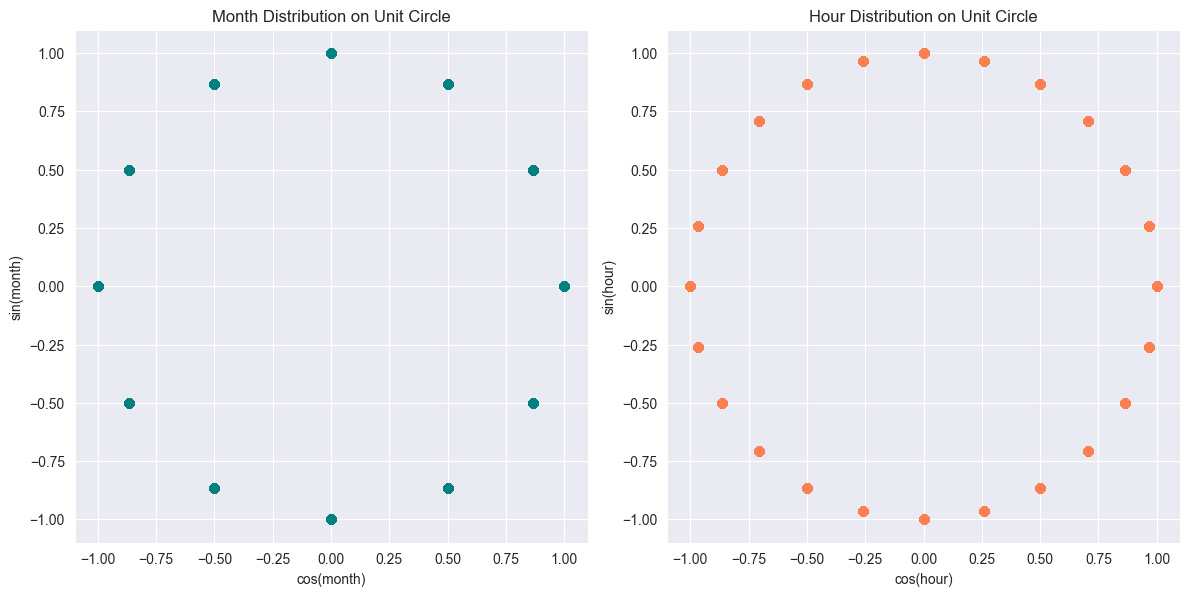

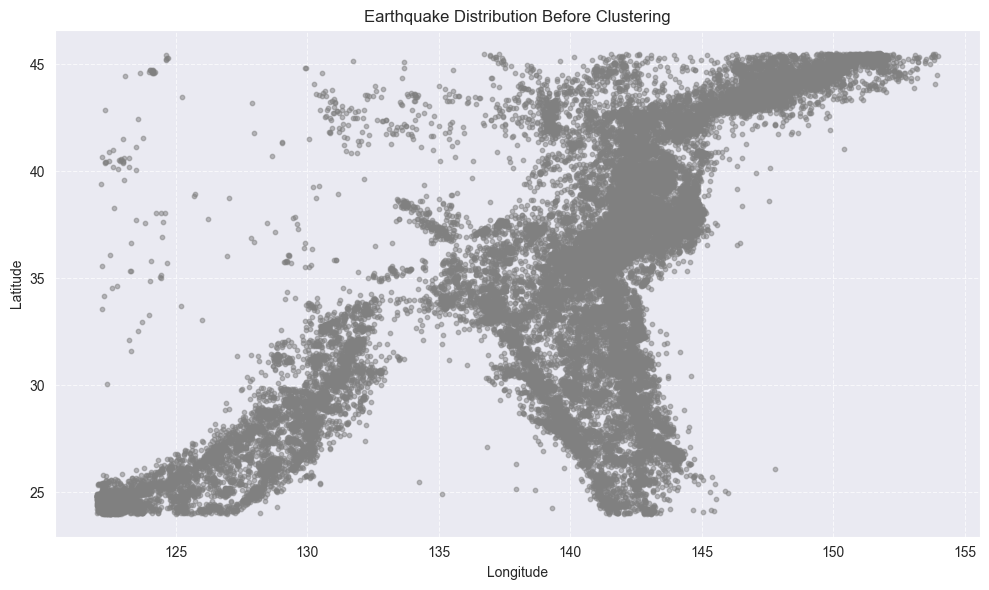

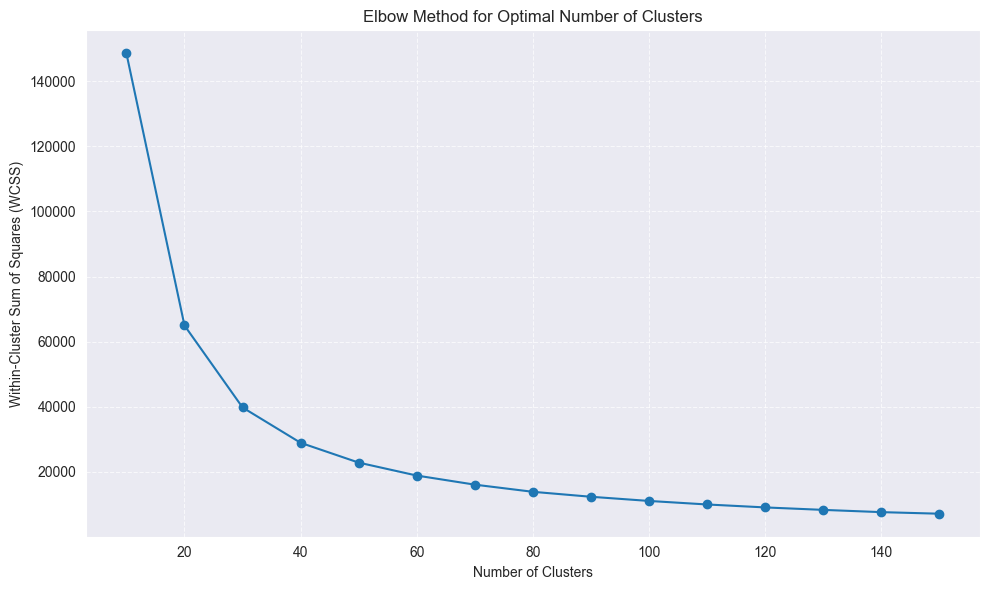

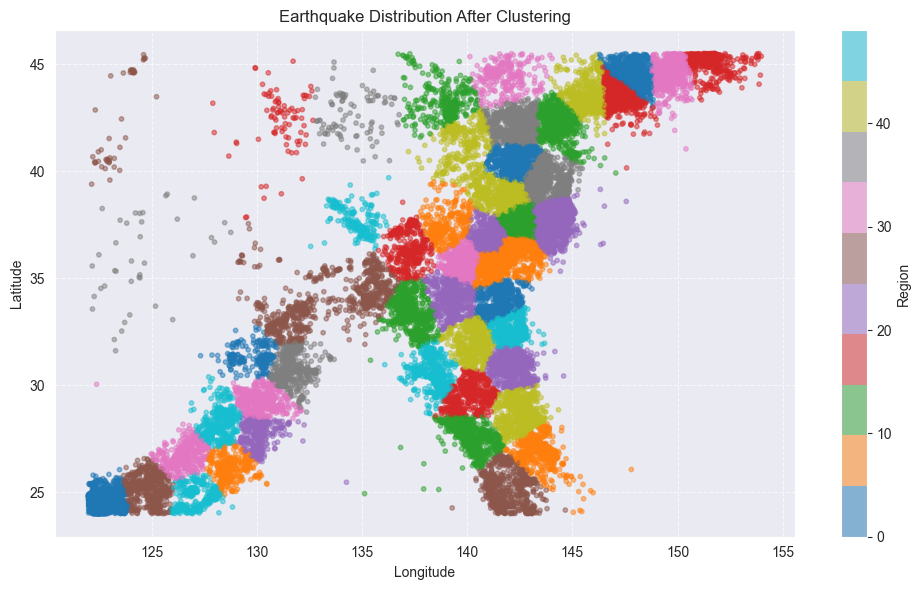

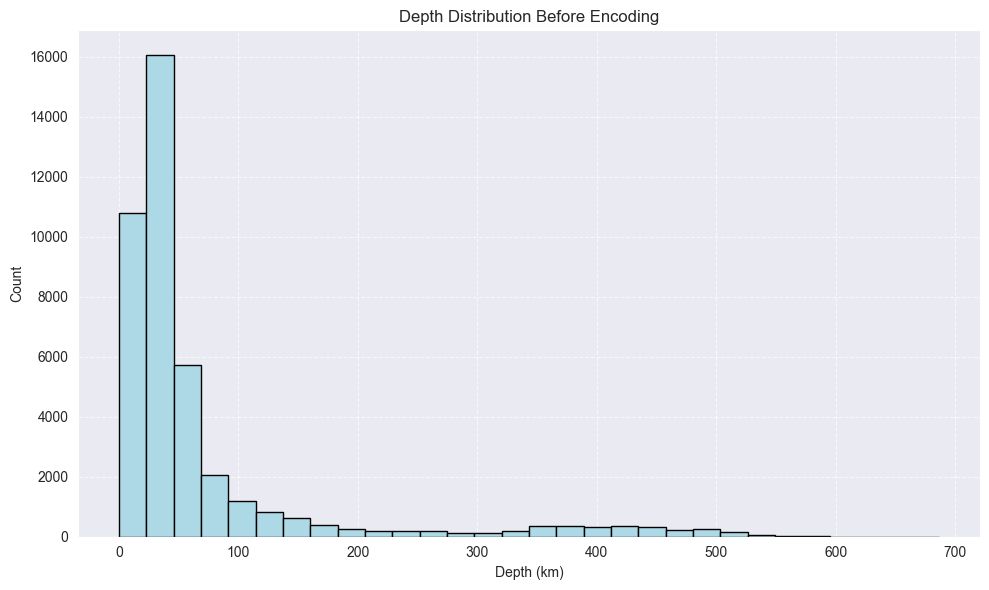

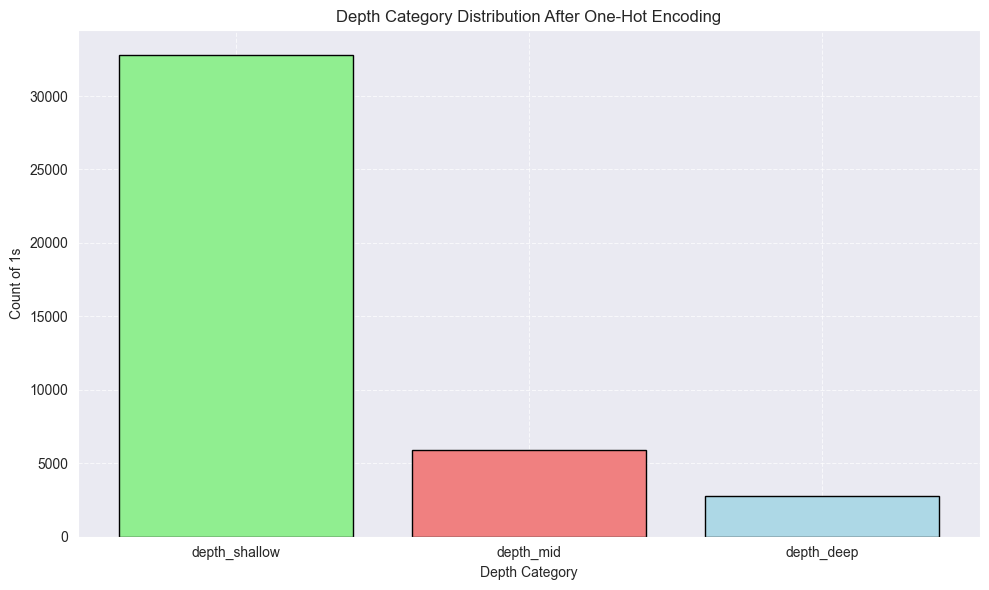

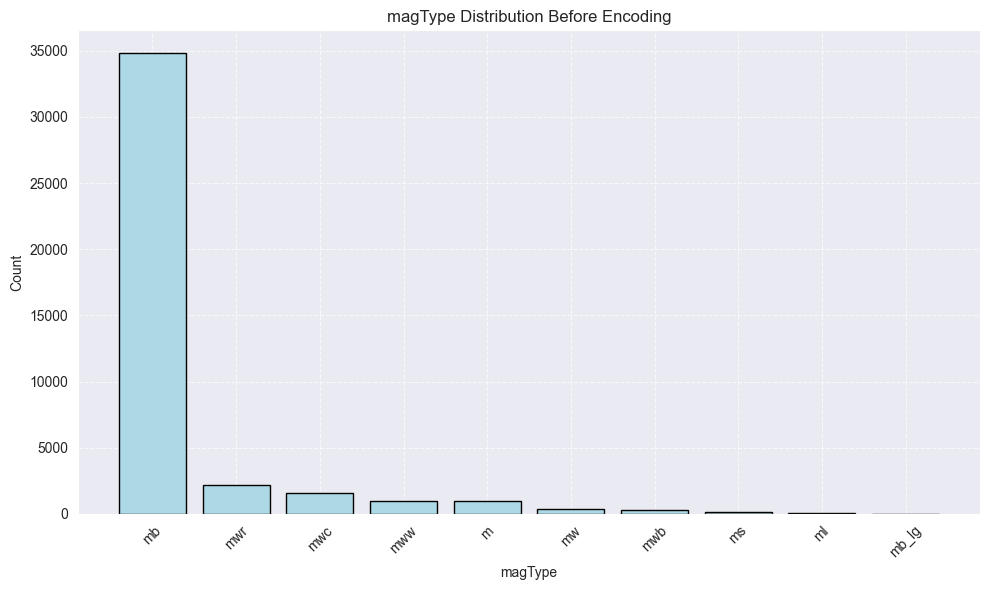

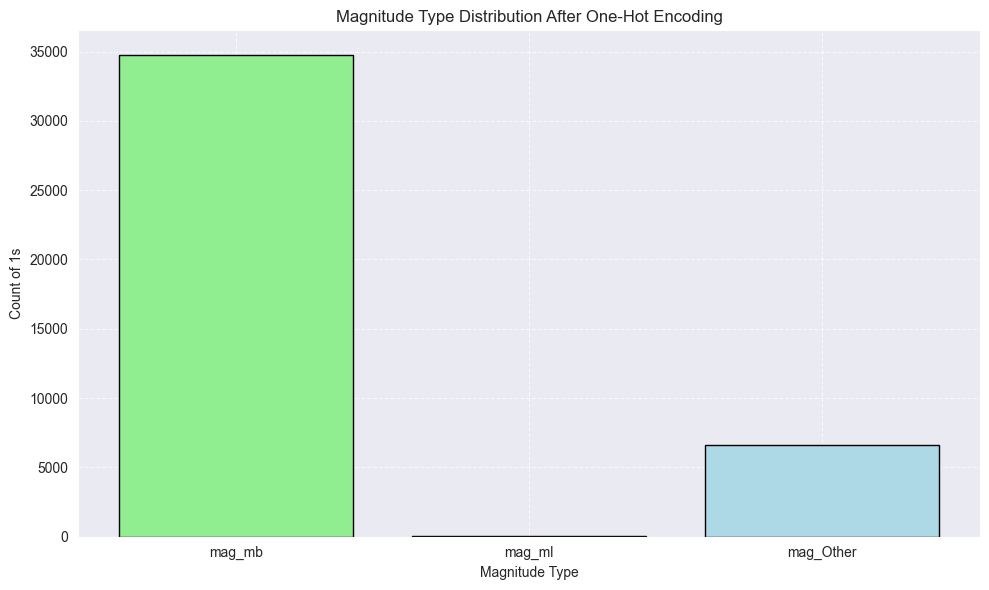


Columns after cleaning and feature engineering:
['latitude', 'longitude', 'depth', 'mag', 'nst', 'gap', 'rms', 'depthError', 'magNst', 'year', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos', 'region', 'depth_shallow', 'depth_mid', 'depth_deep', 'mag_Other', 'mag_mb', 'mag_ml']
✅ Cleaned dataset saved successfully!


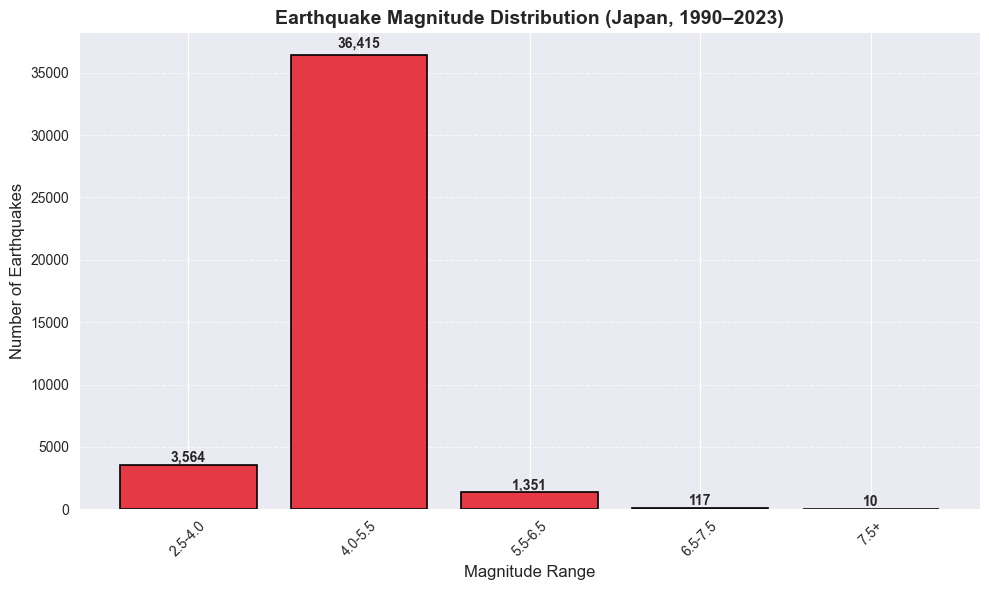

Class distribution before SMOTE:
mag_class
0    40985
1      472
Name: count, dtype: int64
Class distribution after SMOTE:
mag_class
0    40985
1    10000
Name: count, dtype: int64
Total rows after SMOTE: 50985
Resampled magnitude stats:
 count    50985.000000
mean         5.052421
std          1.324310
min          2.700000
25%          4.300000
50%          4.500000
75%          5.100000
max          9.100000
Name: mag, dtype: float64
Current magnitude distribution before downsampling:
 mag_bin
2.5-4.0     3564
4.0-5.5    36415
5.5-6.5     2922
6.5-7.5     3220
7.5+        4864
Name: count, dtype: int64
Downsampled magnitude distribution (4.0-5.5 to 10,000):
 mag_bin
2.5-4.0     3564
4.0-5.5    10000
5.5-6.5     2922
6.5-7.5     3220
7.5+        4864
Name: count, dtype: int64
✅ Oversampled dataset with features saved successfully!


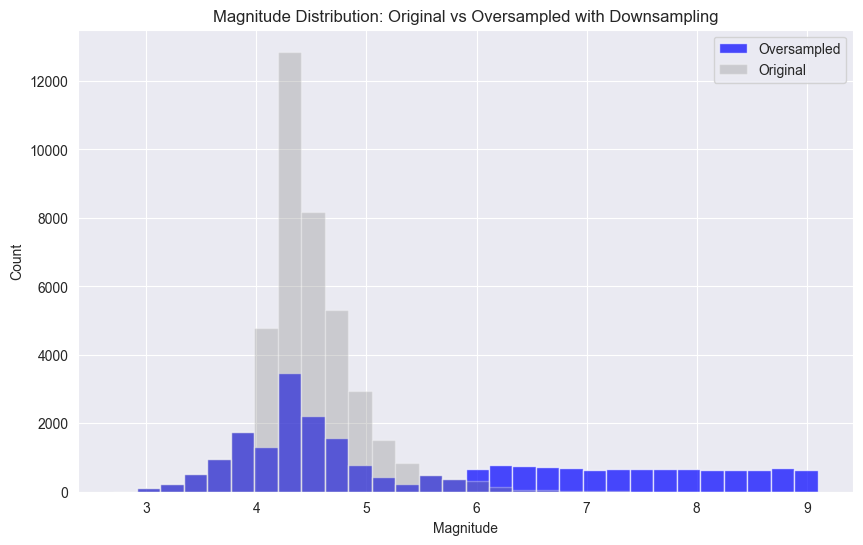

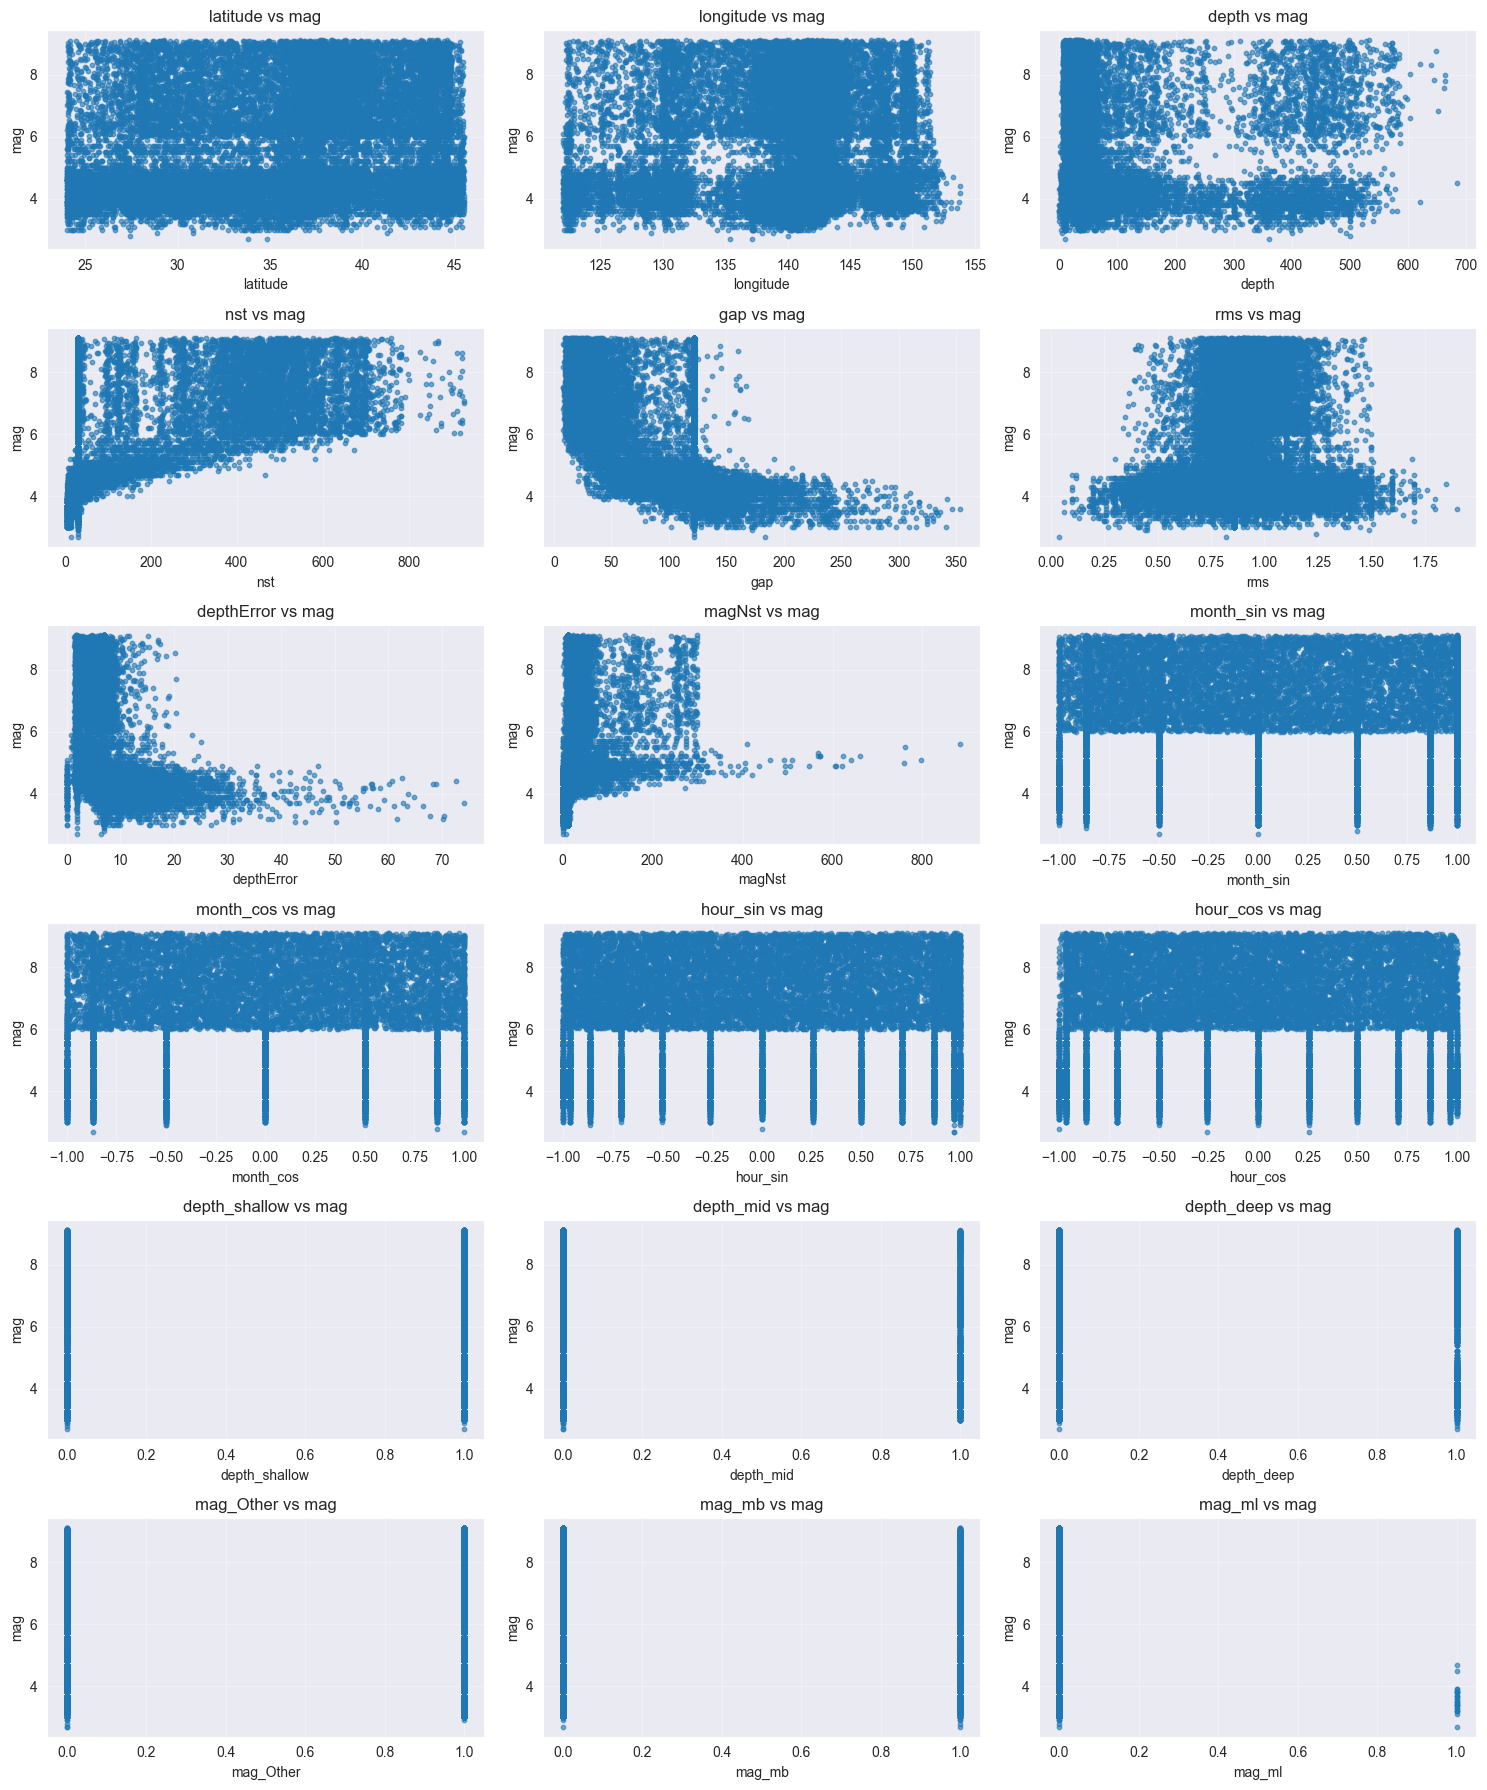

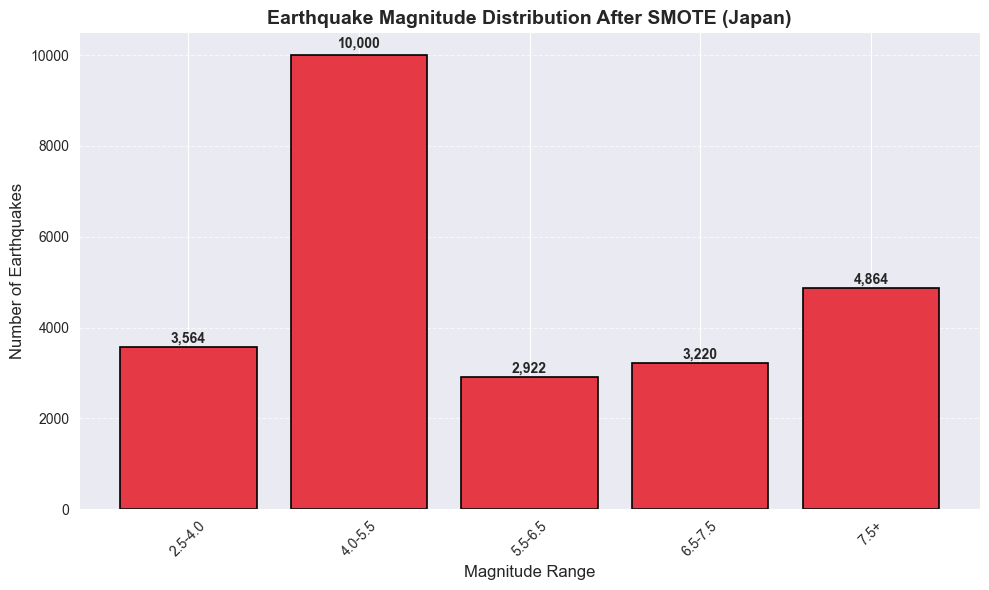

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
import os
import math

# Import Raw Dataset
df = pd.read_csv('japan_earthquakes_combined_filtered.csv')
print("Raw data loaded successfully.")
print(df.shape)
print("Null value counts:\n", df.isnull().sum())

# Initial Inspections
df.info()
df.describe()

# Calculate Missing Value Percentages & Plot
missing_percent = df.isnull().mean() * 100
missing_df = pd.DataFrame({'Column': df.columns, 'Missing (%)': missing_percent}).sort_values(by='Missing (%)', ascending=False)
print("\nMissing Value Percentages:\n", missing_df)

plt.figure(figsize=(10, 6))
missing_df.plot(kind='bar', x='Column', y='Missing (%)', color='salmon', edgecolor='black')
plt.title('Percentage of Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Missing (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axhline(y=50, color='blue', linestyle='--', linewidth=1.5, label='50% Threshold')
plt.legend()
plt.tight_layout()
plt.show()

# Heatmap Plot of Missing Values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=True, cmap='viridis', yticklabels=False)
plt.title('Missing Value Heatmap')
plt.xlabel('Columns')
plt.tight_layout()
plt.show()

# Drop Columns with High Missing Values or Irrelevant
cols_to_drop = [
    'id', 'updated', 'net', 'place', 'type', 'status', 'locationSource', 'magSource',
    'dmin', 'horizontalError', 'magError'
]
df_clean = df.drop(columns=cols_to_drop, errors='ignore')

# Plot Missing Values After Dropping Columns
missing_percent_clean = df_clean.isnull().mean() * 100
missing_df_clean = pd.DataFrame({'Column': df_clean.columns, 'Missing (%)': missing_percent_clean})

plt.figure(figsize=(10, 6))
plt.bar(missing_df_clean['Column'], missing_df_clean['Missing (%)'], color='lightblue')
plt.title('Remaining Missing Values After Drop')
plt.xlabel('Columns')
plt.ylabel('Missing (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Convert Time into Numerical Features
df_clean['time'] = pd.to_datetime(df_clean['time'], errors='coerce')
df_clean['year'] = df_clean['time'].dt.year
df_clean['month'] = df_clean['time'].dt.month
df_clean['hour'] = df_clean['time'].dt.hour
df_clean = df_clean.drop(columns=['time'], errors='ignore')

# Apply Median Imputation for Missing Values
df_clean['nst'] = df_clean['nst'].fillna(df_clean['nst'].median())
df_clean['gap'] = df_clean['gap'].fillna(df_clean['gap'].median())
df_clean['rms'] = df_clean['rms'].fillna(df_clean['rms'].median())
df_clean['depthError'] = df_clean['depthError'].fillna(df_clean['depthError'].median())
df_clean['magNst'] = df_clean['magNst'].fillna(df_clean['magNst'].median())

# Plot Missing Values After Imputation
missing_percent_clean = df_clean.isnull().mean() * 100
missing_df_clean = pd.DataFrame({'Column': df_clean.columns, 'Missing (%)': missing_percent_clean})

plt.figure(figsize=(10, 6))
plt.bar(missing_df_clean['Column'], missing_df_clean['Missing (%)'], color='lightblue')
plt.title('Remaining Missing Values After Imputation')
plt.xlabel('Columns')
plt.ylabel('Missing (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Feature Engineering: Cyclical Time Features
month_counts = df_clean['month'].value_counts()
hour_counts = df_clean['hour'].value_counts()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.pie(month_counts, labels=month_counts.index, colors=['lightblue', 'lightgreen', 'lightcoral', 'gold', 'purple', 'orange', 'pink', 'cyan', 'magenta', 'yellow', 'gray', 'brown'], autopct='%1.1f%%', startangle=90)
plt.title('Month Distribution Before Encoding')

plt.subplot(1, 2, 2)
plt.pie(hour_counts, labels=hour_counts.index, colors=['lightblue', 'lightgreen', 'lightcoral', 'gold', 'purple', 'orange', 'pink', 'cyan', 'magenta', 'yellow', 'gray', 'brown', 'teal', 'lime', 'navy', 'red', 'blue', 'indigo', 'violet', 'maroon', 'olive', 'silver', 'black'], autopct='%1.1f%%', startangle=90)
plt.title('Hour Distribution Before Encoding')
plt.tight_layout()
plt.show()

df_clean['month_sin'] = np.sin(2 * np.pi * df_clean['month'] / 12)
df_clean['month_cos'] = np.cos(2 * np.pi * df_clean['month'] / 12)
df_clean['hour_sin'] = np.sin(2 * np.pi * df_clean['hour'] / 24)
df_clean['hour_cos'] = np.cos(2 * np.pi * df_clean['hour'] / 24)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].scatter(df_clean['month_cos'], df_clean['month_sin'], alpha=0.6, color='teal')
axes[0].set_title('Month Distribution on Unit Circle')
axes[0].set_xlabel('cos(month)')
axes[0].set_ylabel('sin(month)')
axes[0].set_aspect('equal')
axes[0].grid(True)

axes[1].scatter(df_clean['hour_cos'], df_clean['hour_sin'], alpha=0.6, color='coral')
axes[1].set_title('Hour Distribution on Unit Circle')
axes[1].set_xlabel('cos(hour)')
axes[1].set_ylabel('sin(hour)')
axes[1].set_aspect('equal')
axes[1].grid(True)
plt.tight_layout()
plt.show()

df_clean = df_clean.drop(columns=['month', 'hour', 'day'], errors='ignore')

# Feature Engineering: Spatial Clustering
plt.figure(figsize=(10, 6))
plt.scatter(df_clean['longitude'], df_clean['latitude'], color='gray', alpha=0.5, s=10)
plt.title('Earthquake Distribution Before Clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Elbow Method for Optimal Clusters
wcss = []
for i in range(10, 151, 10):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=20, max_iter=300)
    kmeans.fit(df_clean[['latitude', 'longitude']])
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(10, 6))
plt.plot(range(10, 151, 10), wcss, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

kmeans = KMeans(n_clusters=50, random_state=42, n_init=20, max_iter=300)
df_clean['region'] = kmeans.fit_predict(df_clean[['latitude', 'longitude']])

plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_clean['longitude'], df_clean['latitude'], c=df_clean['region'], cmap='tab10', alpha=0.5, s=10)
plt.title('Earthquake Distribution After Clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(scatter, label='Region')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Feature Engineering: Depth Encoding
plt.figure(figsize=(10, 6))
plt.hist(df_clean['depth'], bins=30, color='lightblue', edgecolor='black')
plt.title('Depth Distribution Before Encoding')
plt.xlabel('Depth (km)')
plt.ylabel('Count')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

df_clean['depth'] = pd.to_numeric(df_clean['depth'], errors='coerce').fillna(df_clean['depth'].median())
bin_edges = [0, 70, 300, np.inf]
bin_labels = ['shallow', 'mid', 'deep']
df_clean['depth_bin'] = pd.cut(df_clean['depth'], bins=bin_edges, labels=bin_labels, include_lowest=True)
depth_encoded = pd.get_dummies(df_clean['depth_bin'], prefix='depth', dtype=int)
df_clean = pd.concat([df_clean, depth_encoded], axis=1)
df_clean = df_clean.drop(columns=['depth_bin'])

depth_sums = df_clean[['depth_shallow', 'depth_mid', 'depth_deep']].sum()
plt.figure(figsize=(10, 6))
plt.bar(depth_sums.index, depth_sums.values, color=['lightgreen', 'lightcoral', 'lightblue'], edgecolor='black')
plt.title('Depth Category Distribution After One-Hot Encoding')
plt.xlabel('Depth Category')
plt.ylabel('Count of 1s')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Feature Engineering: Magnitude Type Encoding
df_clean['magType'] = df_clean['magType'].fillna(df_clean['magType'].mode()[0])
magtype_counts = df_clean['magType'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(magtype_counts.index, magtype_counts.values, color='lightblue', edgecolor='black')
plt.title('magType Distribution Before Encoding')
plt.xlabel('magType')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

top_types = ['mb', 'ml', 'md']
df_clean['magType_simple'] = df_clean['magType'].apply(lambda x: x if x in top_types else 'Other')
existing_mag_cols = [col for col in df_clean.columns if col.startswith('mag_')]
if existing_mag_cols:
    df_clean = df_clean.drop(columns=existing_mag_cols)
mag_encoded = pd.get_dummies(df_clean['magType_simple'], prefix='mag', dtype=int)
df_clean = pd.concat([df_clean, mag_encoded], axis=1)
df_clean = df_clean.drop(columns=['magType_simple', 'magType'], errors='ignore')

mag_sums = df_clean[['mag_mb', 'mag_ml', 'mag_Other']].sum()
plt.figure(figsize=(10, 6))
plt.bar(mag_sums.index, mag_sums.values, color=['lightgreen', 'lightcoral', 'lightblue'], edgecolor='black')
plt.title('Magnitude Type Distribution After One-Hot Encoding')
plt.xlabel('Magnitude Type')
plt.ylabel('Count of 1s')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Ensure Final Columns Match Reference
reference_columns = [
    'latitude', 'longitude', 'depth', 'mag', 'nst', 'gap', 'rms', 'depthError', 'magNst',
    'year', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos', 'region',
    'depth_shallow', 'depth_mid', 'depth_deep', 'mag_Other', 'mag_mb', 'mag_ml'
]
missing_cols = [col for col in reference_columns if col not in df_clean.columns]
if missing_cols:
    print(f"Warning: Missing columns {missing_cols}. Adding as zeros.")
    for col in missing_cols:
        df_clean[col] = 0
df_clean = df_clean[reference_columns]

print("\nColumns after cleaning and feature engineering:")
print(df_clean.columns.tolist())

# Save Cleaned Dataset
df_clean.to_csv('cleaned_japan_earthquake.csv', index=False)
print("✅ Cleaned dataset saved successfully!")

# Magnitude Distribution (Original)
bins = [2.5, 4.0, 5.5, 6.5, 7.5, 10.0]
labels = ['2.5-4.0', '4.0-5.5', '5.5-6.5', '6.5-7.5', '7.5+']
df_clean['mag_bin'] = pd.cut(df_clean['mag'], bins=bins, labels=labels, right=False)
dist = df_clean['mag_bin'].value_counts().sort_index()
pct = (dist / len(df_clean) * 100).round(2)

plt.figure(figsize=(10, 6))
bars = plt.bar(dist.index, dist.values, color='#E63946', edgecolor='black', linewidth=1.2)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height + height * 0.01,
             f'{int(height):,}', ha='center', va='bottom', fontweight='bold')
plt.title('Earthquake Magnitude Distribution (Japan, 1990–2023)', fontsize=14, fontweight='bold')
plt.xlabel('Magnitude Range', fontsize=12)
plt.ylabel('Number of Earthquakes', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
df_clean = df_clean.drop(columns=['mag_bin'])

# Apply SMOTE
target = 'mag'
features = [col for col in df_clean.columns if col != target]
original_mags = df_clean['mag'].copy()

# Discretize magnitude into binary class: < 6.0 vs. >= 6.0
df_clean['mag_class'] = (df_clean[target] >= 6.0).astype(int)

# Separate features and target class
X = df_clean[features]
y = df_clean['mag_class']

print("Class distribution before SMOTE:")
print(y.value_counts())

# Initialize SMOTE
smote = SMOTE(sampling_strategy={1: 10000}, random_state=42)

# Apply SMOTE
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Class distribution after SMOTE:")
print(y_resampled.value_counts())
print(f"Total rows after SMOTE: {len(X_resampled)}")

# Reconstruct DataFrame
df_resampled = pd.DataFrame(X_resampled, columns=features)
df_resampled['mag_class'] = y_resampled

# Assign magnitudes
max_mag = df['mag'].max()
num_original = len(original_mags)
df_resampled['mag'] = np.concatenate([
    original_mags,
    np.random.uniform(6.0, max_mag, size=len(df_resampled) - num_original)
])

# Drop the temporary class column
df_resampled = df_resampled.drop(columns=['mag_class'])

print("Resampled magnitude stats:\n", df_resampled['mag'].describe())

# Downsample 4.0-5.5 Magnitude Range
df_resampled['mag_bin'] = pd.cut(df_resampled['mag'], bins=bins, labels=labels, right=False)
dist = df_resampled['mag_bin'].value_counts().sort_index()
print("Current magnitude distribution before downsampling:\n", dist)

target_count = 10000
if dist.get('4.0-5.5', 0) > target_count:
    mask_4_5_5 = (df_resampled['mag_bin'] == '4.0-5.5')
    df_4_5_5 = df_resampled[mask_4_5_5].sample(n=target_count, random_state=42)
    df_resampled = pd.concat([df_resampled[~mask_4_5_5], df_4_5_5]).reset_index(drop=True)

df_resampled['mag_bin'] = pd.cut(df_resampled['mag'], bins=bins, labels=labels, right=False)
dist_downsampled = df_resampled['mag_bin'].value_counts().sort_index()
print("Downsampled magnitude distribution (4.0-5.5 to 10,000):\n", dist_downsampled)

df_resampled = df_resampled.drop(columns=['mag_bin'])

# Save Oversampled Dataset
os.makedirs('oversampled', exist_ok=True)
df_resampled.to_csv('oversampled/japan_earthquake_oversampled_with_features.csv', index=False)
print("✅ Oversampled dataset with features saved successfully!")

# Verify Distribution
plt.figure(figsize=(10, 6))
plt.hist(df_resampled['mag'], bins=30, color='blue', alpha=0.7, label='Oversampled')
plt.hist(df['mag'], bins=30, color='gray', alpha=0.3, label='Original')
plt.xlabel('Magnitude')
plt.ylabel('Count')
plt.title('Magnitude Distribution: Original vs Oversampled with Downsampling')
plt.legend()
plt.show()

# Compare Target Magnitude with Other Features
numerical_features = df_resampled.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_features.remove(target)

plt.figure(figsize=(15, 3 * math.ceil(len(numerical_features) / 3)))
for i, col in enumerate(numerical_features):
    plt.subplot(math.ceil(len(numerical_features) / 3), 3, i + 1)
    plt.scatter(df_resampled[col], df_resampled[target], alpha=0.6, s=10)
    plt.xlabel(col)
    plt.ylabel(target)
    plt.title(f'{col} vs {target}')
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Magnitude Distribution After SMOTE
df_resampled['mag_bin'] = pd.cut(df_resampled['mag'], bins=bins, labels=labels, right=False)
dist = df_resampled['mag_bin'].value_counts().sort_index()
pct = (dist / len(df_resampled) * 100).round(2)

plt.figure(figsize=(10, 6))
bars = plt.bar(dist.index, dist.values, color='#E63946', edgecolor='black', linewidth=1.2)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height + height * 0.01,
             f'{int(height):,}', ha='center', va='bottom', fontweight='bold')
plt.title('Earthquake Magnitude Distribution After SMOTE (Japan)', fontsize=14, fontweight='bold')
plt.xlabel('Magnitude Range', fontsize=12)
plt.ylabel('Number of Earthquakes', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
df_resampled = df_resampled.drop(columns=['mag_bin'])